In [8]:
from matplotlib import pyplot as plt
import pandas as pd
import random
import time
import math
import d2l
import os

from mxnet import autograd, np, npx, gluon, init
from mxnet.gluon import loss as gloss
from mxnet.gluon import rnn
from mxnet.gluon import nn
npx.set_np()

#  09. Modern Recurrent Neural Networks
Although we have learned the basics of recurrent neural networks, they are not sufficient for a practitioner to solve today's sequence learning problems. For instance, given the numerical unstability during gradient calculation, gated recurrent neural networks are much more common in practice. We will begin by introducing two of such widely-used networks, namely `gated recurrent units` (`GRU`) and `long short term memory` (`LSTM`), with illustrations using the same language modeling problem as introduced in `Chapter 8`.

Furthermore, we will modify recurrent neural networks with a single undirectional hidden layer. We will describe deep architectures, and discuss the bidirectional design with both forward and backward recursion. They are frequently adopted in modern recurrent networks.

In fact, a large portion of sequence learning problems such as automatic speech recognition, text to speech, and machine translation, consider both inputs and outputs to be sequences of arbitrary length. Finally, we will take machine translation as an example, and introduce the encoder-decoder architecture based on recurrent neural networks and modern practices for such sequence to sequence learning problems.


## 9.1 Gated Recurrent Units (GRU)
In the previous section, we discussed how gradients are calculated in a recurrent neural network. In particular we found that long products of matrices can lead to vanishing or divergent gradients. Let us briefly think about what such gradient anomalies mean in practice:

+ We might encounter a situation where an early observation is highly significant for predicting all future observations. Consider the somewhat contrived case where the first observation contains a checksum and the goal is to discern whether the checksum is correct at the end of the sequence. In this case, the influence of the first token is vital. We would like to have some mechanisms for storing vital early information in a memory cell. Without such a mechanism, we will have to assign a very large gradient to this observation, since it affects all subsequent observations.

+ We might encounter situations where some symbols carry no pertinent observation. For instance, when parsing a web page there might be auxiliary HTML code that is irrelevant for the purpose of assessing the sentiment conveyed on the page. We would like to have some mechanism for skipping such symbols in the latent state representation.

+ We might encounter situations where there is a logical break between parts of a sequence. For instance, there might be a transition between chapters in a book, or a transition between a bear and a bull market for securities. In this case it would be nice to have a means of resetting our internal state representation.

A number of methods have been proposed to address this. One of the earliest is `Long Short Term Memory` (`LSTM`) (`Hochreiter & Schmidhuber, 1997`) which we will discuss in `Section 9.2`. `Gated Recurrent Unit` (`GRU`) (`Cho et al., 2014`) is a slightly more streamlined variant that often offers comparable performance and is significantly faster to compute. See also (`Chung et al., 2014`) for more details. Due to its simplicity, let us start with the GRU.

### 9.1.1 Gating the Hidden State
The key distinction between regular `RNN` and `GRU` is that the latter support gating of the hidden state. This means that we have dedicated mechanisms for when a hidden state should be updated and also when it should be reset. These mechanisms are learned and they address the concerns listed above. For instance, if the first symbol is of great importance we will learn not to update the hidden state after the first observation. Likewise, we will learn to skip irrelevant temporary observations. Last, we will learn to reset the latent state whenever needed. We discuss this in detail below.

##### Reset Gates and Update Gates
The first thing we need to introduce are reset and update gates. We engineer them to be vectors with entries in $(0, 1)$ such that we can perform convex combinations. For instance, a reset variable would allow us to control how much of the previous state we might still want to remember. Likewise, an update variable would allow us to control how much of the new state is just a copy of the old state.

We begin by engineering gates to generate these variables. `Fig. 9.1.1` illustrates the inputs for both reset and update gates in a `GRU`, given the current timestep input $\mathbf{X}t$ and the hidden state of the previous timestep $\mathbf{H}_{t-1}$. The output is given by a fully connected layer with a sigmoid as its activation function.

<img src="images/09_01.png" style="width:400px;"/>

For a given timestep $t$, the minibatch input is $\mathbf{X}_t \in \mathbb{R}^{n \times d}$ (number of examples: $n$, number of inputs: $d$) and the hidden state of the last timestep is $\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$ (number of hidden states: $h$). Then, the reset gate $\mathbf{R}_t \in \mathbb{R}^{n \times h}$ and update gate $\mathbf{Z}_t \in \mathbb{R}^{n \times h}$ are computed as follows:

$$ \begin{aligned} \mathbf{R}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xr} + \mathbf{H}_{t-1} \mathbf{W}_{hr} + \mathbf{b}_r),\\ \mathbf{Z}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xz} + \mathbf{H}_{t-1} \mathbf{W}_{hz} + \mathbf{b}_z). \end{aligned} $$

Here, $\mathbf{W}_{xr}, \mathbf{W}_{xz} \in \mathbb{R}^{d \times h}$ and $\mathbf{W}_{hr}, \mathbf{W}_{hz} \in \mathbb{R}^{h \times h}$ are weight parameters and $\mathbf{b}_r, \mathbf{b}_z \in \mathbb{R}^{1 \times h}$ are biases. We use a sigmoid function (as introduced in `Section 4.1`) to transform input values to the interval $(0, 1)$.

##### Reset Gates in Action
We begin by integrating the reset gate with a regular latent state updating mechanism. In a conventional RNN, we would have an hidden state update of the form

$$\mathbf{H}_t = \tanh(\mathbf{X}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1}\mathbf{W}_{hh} + \mathbf{b}_h).$$

This is essentially identical to the discussion of the previous section, albeit with a nonlinearity in the form of $\tanh$ to ensure that the values of the hidden states remain in the interval $(-1, 1)$. If we want to be able to reduce the influence of the previous states we can multiply $\mathbf{H}_{t-1}$ with $\mathbf{R}_t$ elementwise. Whenever the entries in the reset gate $\mathbf{R}_t$ are close to $1$, we recover a conventional RNN. For all entries of the reset gate $\mathbf{R}_t$ that are close to $0$, the hidden state is the result of an MLP with $\mathbf{X}_t$ as input. Any pre-existing hidden state is thus reset to defaults. This leads to the following candidate hidden state (it is a candidate since we still need to incorporate the action of the update gate).

$$\tilde{\mathbf{H}}_t = \tanh(\mathbf{X}_t \mathbf{W}_{xh} + \left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{hh} + \mathbf{b}_h).$$

`Fig. 9.1.2` illustrates the computational flow after applying the reset gate. The symbol $\odot$ indicates pointwise multiplication between tensors.

<img src="images/09_02.png" style="width:600px;"/>

##### Update Gates in Action
Next we need to incorporate the effect of the update gate $\mathbf{Z}_t$, as shown in `Fig. 9.1.3`. This determines the extent to which the new state $\mathbf{H}_t$ is just the old state $\mathbf{H}_{t-1}$ and by how much the new candidate state $\tilde{\mathbf{H}}_t$ is used. The gating variable $\mathbf{Z}_t$ can be used for this purpose, simply by taking elementwise convex combinations between both candidates. This leads to the final update equation for the `GRU`.

$$\mathbf{H}_t = \mathbf{Z}_t \odot \mathbf{H}_{t-1} + (1 - \mathbf{Z}_t) \odot \tilde{\mathbf{H}}_t.$$

<img src="images/09_03.png" style="width:600px;"/>

Whenever the update gate $\mathbf{Z}_t$ is close to $1$, we simply retain the old state. In this case the information from $\mathbf{X}_t$ is essentially ignored, effectively skipping timestep $t$ in the dependency chain. In contrast, whenever $\mathbf{Z}_t$ is close to $0$, the new latent state $\mathbf{H}_t$ approaches the candidate latent state $\tilde{\mathbf{H}}_t$. These designs can help us cope with the vanishing gradient problem in RNNs and better capture dependencies for time series with large timestep distances. In summary, GRUs have the following two distinguishing features:
+ Reset gates help capture short-term dependencies in time series.
+ Update gates help capture long-term dependencies in time series.

### 9.1.2 Implementation from Scratch
To gain a better understanding of the model, let us implement a `GRU` from scratch.

##### Reading the Dataset
We begin by reading The Time Machine corpus that we used in `Section 8.5`. The code for reading the dataset is given below:

In [2]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

##### Initializing Model Parameters
The next step is to initialize the model parameters. We draw the weights from a `Gaussian` with variance to be $0.01$ and set the bias to $0$. The hyperparameter `num_hiddens` defines the number of hidden units. We instantiate all weights and biases relating to the update gate, the reset gate, and the candidate hidden state itself. Subsequently, we attach gradients to all the parameters.

In [3]:
def get_params(vocab_size, num_hiddens, ctx):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return np.random.normal(scale=0.01, size=shape, ctx=ctx)

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                np.zeros(num_hiddens, ctx=ctx))

    W_xz, W_hz, b_z = three()  # Update gate parameter
    W_xr, W_hr, b_r = three()  # Reset gate parameter
    W_xh, W_hh, b_h = three()  # Candidate hidden state parameter
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = np.zeros(num_outputs, ctx=ctx)
    # Attach gradients
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.attach_grad()
    return params

##### Defining the Model
Now we will define the hidden state initialization function `init_gru_state`. Just like the `init_rnn_state` function defined in `Section 8.5`, this function returns a tensor with a shape `(batch size, number of hidden units)` whose values are all zeros.

In [4]:
def init_gru_state(batch_size, num_hiddens, ctx):
    return (np.zeros(shape=(batch_size, num_hiddens), ctx=ctx), )

Now we are ready to define the `GRU` model. Its structure is the same as the basic `RNN` cell, except that the update equations are more complex.

In [5]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = npx.sigmoid(np.dot(X, W_xz) + np.dot(H, W_hz) + b_z)
        R = npx.sigmoid(np.dot(X, W_xr) + np.dot(H, W_hr) + b_r)
        H_tilda = np.tanh(np.dot(X, W_xh) + np.dot(R * H, W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = np.dot(H, W_hq) + b_q
        outputs.append(Y)
    return np.concatenate(outputs, axis=0), (H,)

##### Training and Prediction
Training and prediction work in exactly the same manner as before. After training for one epoch, the perplexity and the output sentence will be like the following.

Perplexity 1.1, 9133 tokens/sec on cpu(0)
time traveller  it s against reason said filby  what reason said
traveller  it s against reason said filby  what reason said


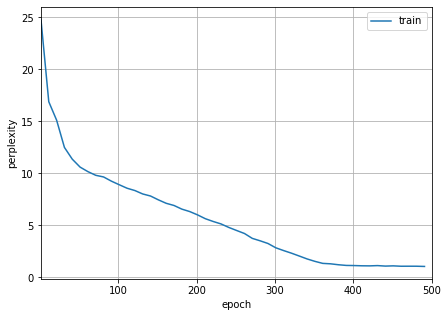

In [6]:
vocab_size, num_hiddens, ctx = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, ctx, get_params, init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, ctx)

### 9.1.3 Concise Implementation
In `Gluon`, we can directly call the `GRU` class in the `rnn` module. This encapsulates all the configuration detail that we made explicit above. The code is significantly faster as it uses compiled operators rather than Python for many details that we spelled out in detail before.

Perplexity 1.1, 5799 tokens/sec on cpu(0)
time traveller for so it will be convenient to speak of him was 
traveller  it s against reason said filby  what reason said


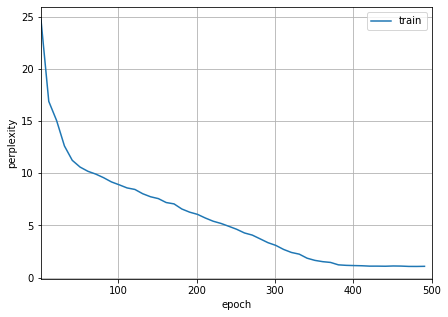

In [9]:
gru_layer = rnn.GRU(num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, ctx)

##### Summary
+ Gated recurrent neural networks are better at capturing dependencies for time series with large timestep distances.
+ Reset gates help capture short-term dependencies in time series.
+ Update gates help capture long-term dependencies in time series.
+ GRUs contain basic RNNs as their extreme case whenever the reset gate is switched on. They can ignore sequences as needed.

##### Exercises
1. Compare runtime, perplexity, and the output strings for rnn.RNN and rnn.GRU implementations with each other.
2. Assume that we only want to use the input for timestep $t'$ to predict the output at timestep $t > t'$. What are the best values for the reset and update gates for each timestep?
3. Adjust the hyperparameters and observe and analyze the impact on running time, perplexity, and the written lyrics.
4. What happens if you implement only parts of a GRU? That is, implement a recurrent cell that only has a reset gate. Likewise, implement a recurrent cell only with an update gate.